# Regression with MNIST-1D

In order to make our lives a bit easier, we will use a simplified dataset called [MNIST1D](https://github.com/greydanus/mnist1d). This dataset is small and yet exposes quite some intricacies.

In [1]:
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
import requests
import torch
import tempfile

from functools import partial
from lightning_uq_box.uq_methods import MVEPxRegression, DeepEnsemblePxRegression
from matplotlib.lines import Line2D

# set the seeds to make the notebook reproducible
L.seed_everything(41)

Seed set to 41


41

Download the MNIST1d demo dataset at [this URL](https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl) using your browser
or download the dataset directly from this notebook by uncommenting the following lines:

In [2]:
data_filename = "mnist1d_data.pkl"
with open(data_filename, "wb") as out_file:
    out_file.write(
        requests.get(
            "https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl"
        ).content
    )

In [3]:
# load the dataset into this notebook
output = Path(f"./{data_filename}")
data = pickle.load(output.open("rb"))

## Step 1: Visualize dataset

The dataset is inspired by the original MNIST dataset, but it is way smaller and 1D only in the input domain.

In [4]:
x = data["x"]
y = data["y"]
x_test = data["x_test"]
y_test = data["y_test"]
t = data["t"]
print("training", x.shape, y.shape)
print("test", x_test.shape, y_test.shape)

training (4000, 40) (4000,)
test (1000, 40) (1000,)


## Step 2: Normalization

The signal in the mnist1d dataset is not normalized. We need to perform normalization before we can proceed. We choose a min-max normalization.

In [5]:
xmin, xmax = x.min(), x.max()
print(f"min/max of x: {xmin, xmax}")

min/max of x: (-5.479419072154895, 4.533515672898283)


In [6]:
x_ = (x - xmin) / (xmax - xmin)
x_test_ = (
    (x_test - xmin) / (xmax - xmin)
)  # we need to apply the same normalization constants to the test set which we obtained from the training data!

print(
    f"normalization: raw min/max {x.min(), x.max()} -> normed min/max {x_.min(), x_.max()}"
)

normalization: raw min/max (-5.479419072154895, 4.533515672898283) -> normed min/max (0.0, 1.0)


## Step 3: Prepare training

Torch requires a channel dimension when it comes to the encoding of the inputs. We therefore need to inject a dimension in all data.

In [7]:
x_ = np.expand_dims(x_, axis=1)
assert x_.shape == (
    x.shape[0],
    1,
    x.shape[-1],
), f"{x_.shape} does not match {x.shape[0], 1, x.shape[-1]}"
x_test_ = np.expand_dims(x_test_, axis=1)
y = np.expand_dims(y, axis=1)
y_test = np.expand_dims(y_test, axis=1)

print(f"shapes of x {x_.shape} and y {y.shape} for training")
print(f"shapes of x {x_test_.shape} and y {y_test.shape} for testing")

shapes of x (4000, 1, 40) and y (4000, 1) for training
shapes of x (1000, 1, 40) and y (1000, 1) for testing


MNIST1D was originally designed as a dataset for classification. Let's create a multivariate regression tproblem from this by masking out parts of the input signal which we want the model to learn to reconstruct. The masked portions of the data will be set to a constant value, e.g. `0.5`. The task of the network will be to replace the masked portions with predictions that are as close as possible to the original. Thus, we will have

- `x` - signals from mnist1d with some portion of the signal being set to a fixed value
- `y` - the original of mnist1dt to predict given `x`

In [8]:
# the unaltered signal will become the labels
y = x_.copy()
y_test = x_test_.copy()

mask_slice = slice(0, 6)  # index range to replace
constant = 0.5  # value to replace

# the inputs now get altered by masking out parts of the signal
x_[:, 0, mask_slice] = constant
x_test_[:, 0, mask_slice] = constant

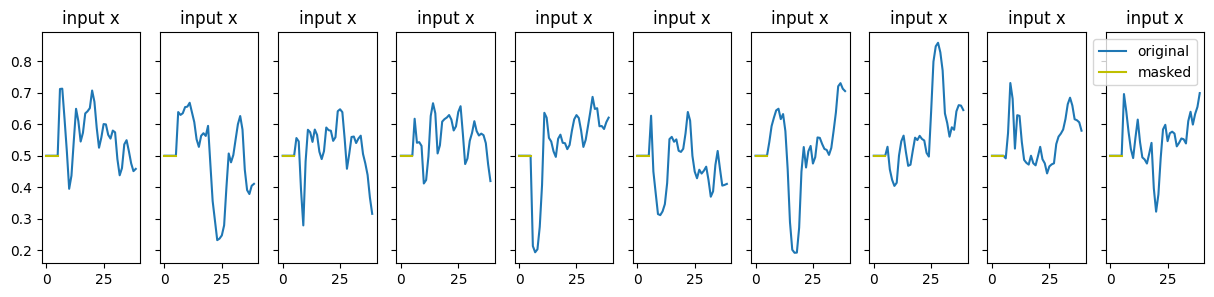

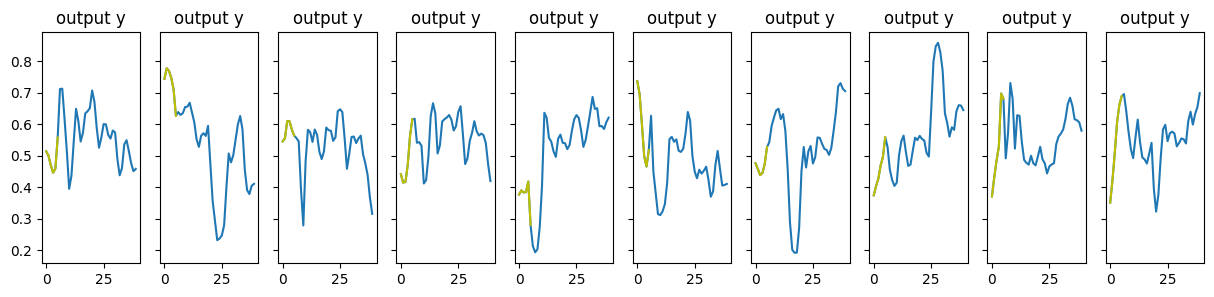

In [9]:
# let's plot the result using the first 10 samples
n = 10
xaxis = np.arange(0, y.shape[-1], 1)
fig, ax = plt.subplots(1, n, figsize=(15, 3), sharey=True)
for i in range(n):
    ax[i].plot(xaxis, x_[i, 0, ...], label="original")
    ax[i].plot(xaxis[mask_slice], x_[i, 0, mask_slice], color="y", label="masked")
    ax[i].set_title(f"input x")
ax[n - 1].legend()


fig, ax = plt.subplots(1, n, figsize=(15, 3), sharey=True)
for i in range(n):
    ax[i].plot(xaxis, y[i, 0, ...], label="original")
    ax[i].plot(xaxis[mask_slice], y[i, 0, mask_slice], color="y", label="masked")
    ax[i].set_title(f"output y")

Convert everything to a `torch.Tensor` object.

In [10]:
x_, y = torch.tensor(x_, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [11]:
x_test_, y_test = (
    torch.tensor(x_test_, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32),
)

In [12]:
x_.shape

torch.Size([4000, 1, 40])

#### Creating the CNN model

In [13]:
def create_fcn(inshape=x_.shape, channels=32, dropout=0.3, nlayers=3):
    "a fully 1D convolutional network (fcn) to process the input signal"
    "and convert it into an output signal of the same shape."

    # this model is adopted from https://github.com/greydanus/mnist1d/blob/39dd6c03785eefe60f349af94e61f864fc449644/models.py#L36

    layers = []
    for lidx in range(nlayers):
        if lidx == 0:
            inchan = inshape[1]
            outchan = channels
        else:
            inchan = channels
            outchan = channels

        layers.append(
            torch.nn.Conv1d(inchan, outchan, kernel_size=3, stride=1, padding=1)
        )  # S=1, P=1, K=3 keeps dimensionality intact
        layers.append(torch.nn.ReLU())

    layers.append(torch.nn.Dropout(p=dropout))
    layers.append(
        torch.nn.Conv1d(channels, inshape[-1], kernel_size=3, stride=1, padding=1)
    )  # S=1, P=1, K=3 keeps dimensionality
    layers.append(torch.nn.ReLU())

    # get back to a single channel to resemble input dimensionality by averaging channels for each pixel using a 1x1 convolution.
    # we use twice as many output channels as the original input because we predict
    # both mu and sigma with this network
    layers.append(torch.nn.Conv1d(inshape[-1], 2 * inshape[1], kernel_size=1))
    # to get back to output range of [0,1]
    # torch.nn.Sigmoid()
    # layers.append(torch.nn.ReLU())

    return torch.nn.Sequential(*layers)

In [14]:
model_args = dict(channels=48, dropout=0.65, nlayers=3)

model = create_fcn(x_.shape, **model_args)

# wrap the torch module into the MVE class that takes care of proper training.
# this gives one member of the ensemble
ensemble_member = MVEPxRegression(
    model, optimizer=partial(torch.optim.Adam, lr=0.001, betas=(0.9, 0.999), eps=1.0e-7)
)
ensemble_member

MVEPxRegression(
  (model): Sequential(
    (0): Conv1d(1, 48, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(48, 48, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(48, 48, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU()
    (6): Dropout(p=0.65, inplace=False)
    (7): Conv1d(48, 40, kernel_size=(3,), stride=(1,), padding=(1,))
    (8): ReLU()
    (9): Conv1d(40, 2, kernel_size=(1,), stride=(1,))
  )
  (loss_fn): NLL()
  (train_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (RMSE): MeanSquaredError(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (RMSE): MeanSquaredError(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (RMSE): MeanSquaredError(),
    prefix=test
  )
)

In [15]:
# check if model prediction works
n_samples = 3
x_example = x_[:n_samples]
print(x_example.shape)
out = ensemble_member(x_example)
print(f"MVEPxRegression forward pass returns {out.shape}")
print()
pred_dict = ensemble_member.predict_step(x_example)
for k in pred_dict:
    print(k, pred_dict[k].shape)

torch.Size([3, 1, 40])
MVEPxRegression forward pass returns torch.Size([3, 2, 40])

pred torch.Size([3, 1, 40])


## Step 4: Training of ensembles of models

#### Create a deep ensemble based estimate

The idea of Deep Ensembles was published in 2017 in
http://arxiv.org/abs/1612.01474.

The core idea is to train multiple models on the same dataset. Each model then acts as a predictor to sample the uncertainties predicted. To this end, the more predictors you train, the longer your training will last as this is performed sequentially here, but, in theory this could also be parallelized.



In [16]:
batch_size = 128
epochs = 15
validation_interval = 1  # every how many epochs should we run validation

In [17]:
def collate_to_dict(samples):
    """
    The library expects batches to be dictionaries with 'input' and 'target'
    keys, which get created using this custom collate function in the dataloader.
    """
    # print("samples is", samples)
    # print("len(samples)", len(samples))
    # print(len(samples[0]), samples[0][0].shape)

    return {
        "input": torch.stack([s[0] for s in samples]),
        "target": torch.stack([s[1] for s in samples]),
    }


train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_, y),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_to_dict,
)

val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test_, y_test),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_to_dict,
)

In [18]:
n_ensembles = 8  # number of models to be trained
trained_models_nll = []
my_temp_dir = Path(tempfile.mkdtemp())

for i in range(n_ensembles):
    model = create_fcn(x_.shape, **model_args)
    ensemble_member = MVEPxRegression(
        model,
        optimizer=partial(torch.optim.Adam, lr=0.001, betas=(0.9, 0.999), eps=1.0e-7),
    )

    trainer = L.Trainer(
        max_epochs=epochs,
        limit_val_batches=0,
        num_sanity_val_steps=0,
        enable_checkpointing=False,
        default_root_dir=my_temp_dir / f"member_{i}",
        check_val_every_n_epoch=validation_interval,
    )
    trainer.fit(ensemble_member, train_loader, val_loader)

    save_path = my_temp_dir / f"model_nll_{i}.ckpt"
    trainer.save_checkpoint(save_path)
    trained_models_nll.append({"base_model": ensemble_member, "ckpt_path": save_path})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tmp/tmpss0xrae2/member_0/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 20.0 K
1 | loss_fn       | NLL              | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)
/home/starke88/git/haicu/nn-ensembles/lub/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_w

Training: |                                            | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tmp/tmpss0xrae2/member_1/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 20.0 K
1 | loss_fn       | NLL              | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)


Training: |                                            | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tmp/tmpss0xrae2/member_2/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 20.0 K
1 | loss_fn       | NLL              | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)


Training: |                                            | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tmp/tmpss0xrae2/member_3/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 20.0 K
1 | loss_fn       | NLL              | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)


Training: |                                            | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tmp/tmpss0xrae2/member_4/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 20.0 K
1 | loss_fn       | NLL              | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)


Training: |                                            | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tmp/tmpss0xrae2/member_5/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 20.0 K
1 | loss_fn       | NLL              | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)


Training: |                                            | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tmp/tmpss0xrae2/member_6/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 20.0 K
1 | loss_fn       | NLL              | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)


Training: |                                            | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tmp/tmpss0xrae2/member_7/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 20.0 K
1 | loss_fn       | NLL              | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)


Training: |                                            | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


## Step 5: Model inference - How to do predictions?

We average across all predictions. The core assumption of the DeepEnsemble approach is, that a prediction is created by a Gaussian mixture model, where mixture elements are the individual model predictions, which are considered to be gaussian as well.

In [19]:
def collate_for_pred(samples):
    # samples = list of 1tuples which we have to combine

    samp = [s[0] for s in samples]
    return torch.stack(samp, dim=0)


# NOTE: this dataloader does not include the ground truth labels to
# reflect real-world usage of applying the models on unlabeled data
inference_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test_),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_for_pred,
)

In [20]:
# Ensembling of the individual model predictions is handled for us conveniently
deep_ens_nll = DeepEnsemblePxRegression(
    n_ensemble_members=n_ensembles, ensemble_members=trained_models_nll
)

# this gives a list of dict, one entry for each batch
# dict keys are
#  'pred',            - the average of the 'mean' output across all ensemble members (i.e. average over first entry of second dimension in the data), shape B x 1 x X
#  'pred_uct',        - the final variance of Lakshminarayanan2017/Kendall 2017 eq. 9, combining the means and sigmas across all ensemble members, shape B x X
#  'epistemic_uct',   - the empirical standard deviation of the 'mean' outputs across ensemble members
#  'aleatoric_uct'    - sqrt of the average of the 'sigma^2' outputs across all ensemble members
# so a version of the pythagorean theorem holds: 'aleatoric_uct'^2 + 'epistemic_uct'^2 = 'pred_uct'^2
list_of_pred_dict = trainer.predict(deep_ens_nll, inference_loader)

/home/starke88/git/haicu/nn-ensembles/lub/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                          | 0/? [00:00<?, ?it/s]

In [21]:
# for each dict entry stack over batches
def convert_list_of_dict(list_of_dict):
    """
    This converts the batch-oriented list-of-dict data structure
    returned by trainer.predict to the more convenient form of
    a single dict, where values are aggregated for the entire dataset.
    """
    keys = list_of_dict[0].keys()

    retval = dict()
    for k in keys:
        retval[k] = torch.cat([d[k] for d in list_of_dict])

    return retval


preds = convert_list_of_dict(list_of_pred_dict)

print("Deep ensemble predictions\n")
for k, v in preds.items():
    print(k, v.shape)

Deep ensemble predictions

pred torch.Size([1000, 1, 40])
pred_uct torch.Size([1000, 40])
epistemic_uct torch.Size([1000, 40])
aleatoric_uct torch.Size([1000, 40])


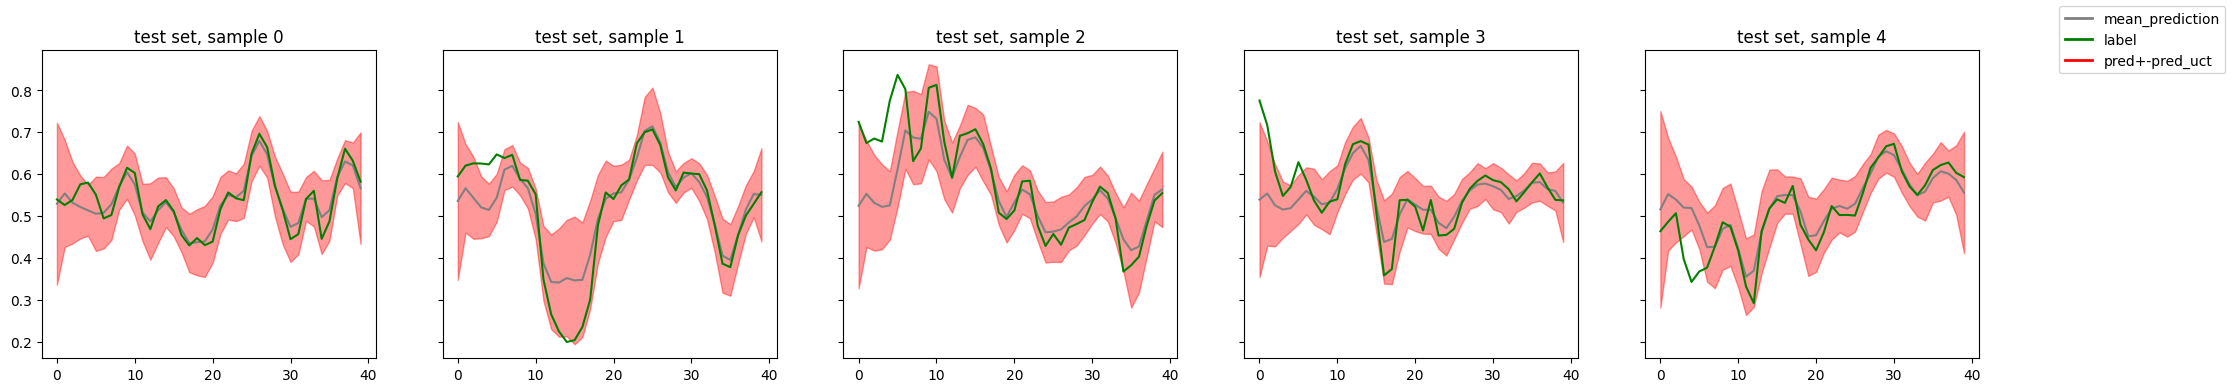

In [22]:

# we plot some samples together with their predictions and estimated
# uncertainties
n = 5
custom_lines = [
    Line2D([0], [0], color="grey", lw=2),
    Line2D([0], [0], color="green", lw=2),
    Line2D([0], [0], color="red", lw=2),
]

fig, ax = plt.subplots(1, n, figsize=(n * 5, 4), sharey=True)
for i in range(n):
    mean_pred = preds["pred"][i, 0].cpu().numpy()
    std_pred = preds["pred_uct"][i].cpu().numpy()
    # std_aleatoric = preds["aleatoric_uct"].cpu().numpy()
    # std_epistemic = preds["epistemic_uct"].cpu().numpy()

    xaxis = np.arange(0, x.shape[-1], 1)
    ax[i].plot(xaxis, mean_pred, color="grey", label="mean_prediction")
    ax[i].plot(xaxis, y_test[i, 0, ...], color="green", label="label")
    ax[i].set_title(f"test set, sample {i}")
    ax[i].fill_between(
        xaxis, mean_pred - std_pred, mean_pred + std_pred, color="red", alpha=0.4
    )

fig.legend(custom_lines, ["mean_prediction", "label", "pred+-pred_uct"])
# fig.savefig("deepensemble_regression_mv.pdf")

plt.show()

# Step 6: Calibration plots

An important aspect of uncertainty quantification is to assess if the uncertainties are of high quality. Note, this simultaneously assesses the calibration across all entries of the prediction and hence might not show whether uncertainties are better calibrated in certain ranges of the signal domain.

In [23]:
from uncertainty_toolbox.viz import plot_calibration

y_mean = preds["pred"].cpu().numpy()  # B x 1 x X
y_std = preds["pred_uct"].unsqueeze(1).cpu().numpy()  # B x 1 x X
print(y_mean.shape, y_std.shape, y_test.numpy().shape)

(1000, 1, 40) (1000, 1, 40) (1000, 1, 40)


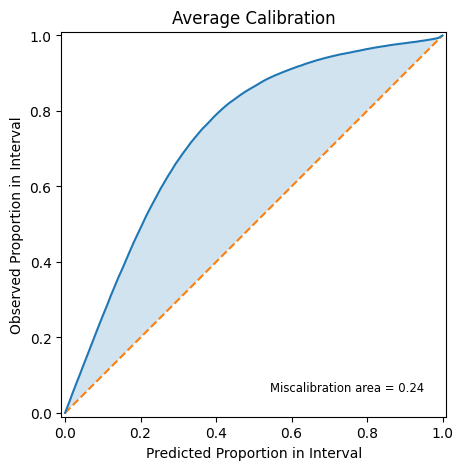

In [24]:
ax = plot_calibration(y_mean.flatten(), y_std.flatten(), y_test.numpy().flatten())

As the calibration curve is above the diagonal, we would consider this DeepEnsemble approximation quite bad and unusable. The miscalibration area is rather large which suggests that our predictor is underconfident and we should probably consider methods for recalibrating our uncertainties or try out other models for better performance.

## Step 7: Clean-up

In case you do not want to keep the trained models and logging information, the created data should be removed. Uncomment the line below to do this.

In [25]:
import shutil

# shutil.rmtree(my_temp_dir)

PosixPath('/tmp/tmpss0xrae2')